### 0. 루브릭
---
- 3가지 이상의 모델이 성공적으로 시도됨
- gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함
- 네이버 영화리뷰 데이터 감성분석 정확도를 90% 이상 달성함

### 1. 데이터 준비와 확인
---

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/project/aiffel-lms/E9_Embedding/ratings_train.txt')
test_data = pd.read_table('~/project/aiffel-lms/E9_Embedding/ratings_test.txt')

print(train_data.shape)
print(test_data.shape)

train_data.head()

(150000, 3)
(50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2. 데이터로더 구성
---

실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


### 3) 모델구성을 위한 데이터 분석 및 가공
---
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균:', np.mean(num_tokens))
print('문장길이 최대:', np.max(num_tokens))
print('문장길이 표준편차:', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

print('패딩문장 최대길이:', maxlen)
print('전체 문장의 {}%가 maxlen 설정 이내에 포함됩니다'.format(np.sum(num_tokens < max_tokens)/len(num_tokens) * 100))

문장길이 평균: 15.969376315021577
문장길이 최대: 116
문장길이 표준편차: 12.843535456326455
패딩문장 최대길이: 41
전체 문장의 93.42988343341575%가 maxlen 설정 이내에 포함됩니다


In [6]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index['<PAD>'], 
                                                    padding='pre', maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index['<PAD>'], 
                                                    padding='pre', maxlen=maxlen)

print(x_train.shape)
print(y_train.shape)

(146182, 41)
(146182,)


### 4) 모델구성 및 validation set 구성
---
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.



In [7]:
# validation set 10000건 분리
x_val = x_train[:60000]   
y_val = y_train[:60000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[60000:]  
partial_y_train = y_train[60000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(86182, 41)
(86182,)


### 모델 1

In [8]:
vocab_size = 10000
word_vector_dim = 32

model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 328,865
Trainable params: 328,865
Non-trainable params: 0
_________________________________________________________________


### 모델 2

In [9]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 32  # 어휘 사전의 크기입니다(10개의 단어)

model_2 = keras.Sequential()
model_2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(keras.layers.MaxPooling1D(5))
model_2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(keras.layers.GlobalMaxPooling1D())
model_2.add(keras.layers.Dense(8, activation='relu'))
model_2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### 모델 3

In [10]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 32  # 어휘 사전의 크기입니다(10개의 단어)

model_3 = keras.Sequential()
model_3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(keras.layers.GlobalMaxPooling1D())
model_3.add(keras.layers.Dense(8, activation='relu'))
model_3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시
--- 

### 모델 1

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)



Epoch 1/5
1347/1347 [==============================] - 8s 6ms/step - loss: 0.3994 - accuracy: 0.8178 - val_loss: 0.3465 - val_accuracy: 0.8479
Epoch 2/5
1347/1347 [==============================] - 8s 6ms/step - loss: 0.3170 - accuracy: 0.8635 - val_loss: 0.3421 - val_accuracy: 0.8505
Epoch 3/5
1347/1347 [==============================] - 7s 5ms/step - loss: 0.2768 - accuracy: 0.8816 - val_loss: 0.3381 - val_accuracy: 0.8542
Epoch 4/5
1347/1347 [==============================] - 7s 6ms/step - loss: 0.2407 - accuracy: 0.8987 - val_loss: 0.3496 - val_accuracy: 0.8526
Epoch 5/5
1347/1347 [==============================] - 8s 6ms/step - loss: 0.2113 - accuracy: 0.9125 - val_loss: 0.3805 - val_accuracy: 0.8515


In [12]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3844 - accuracy: 0.8474
[0.38440510630607605, 0.8474479913711548]


In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 모델 2

In [14]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_2 = model_2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)



Epoch 1/5
2694/2694 [==============================] - 17s 6ms/step - loss: 0.3895 - accuracy: 0.8178 - val_loss: 0.3316 - val_accuracy: 0.8553
Epoch 2/5
2694/2694 [==============================] - 12s 4ms/step - loss: 0.2749 - accuracy: 0.8857 - val_loss: 0.3345 - val_accuracy: 0.8548
Epoch 3/5
2694/2694 [==============================] - 11s 4ms/step - loss: 0.1973 - accuracy: 0.9229 - val_loss: 0.3766 - val_accuracy: 0.8444
Epoch 4/5
2694/2694 [==============================] - 11s 4ms/step - loss: 0.1300 - accuracy: 0.9525 - val_loss: 0.4568 - val_accuracy: 0.8447
Epoch 5/5
2694/2694 [==============================] - 11s 4ms/step - loss: 0.0921 - accuracy: 0.9675 - val_loss: 0.5273 - val_accuracy: 0.8404


In [15]:
results = model_2.evaluate(x_test,  y_test, verbose=1)

print(results)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.5386 - accuracy: 0.8379
[0.5386026501655579, 0.8379274606704712]


In [16]:
history_dict_2 = history_2.history
print(history_dict_2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 모델 3

In [17]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_3 = model_3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1347/1347 [==============================] - 5s 4ms/step - loss: 0.4357 - accuracy: 0.8078 - val_loss: 0.3566 - val_accuracy: 0.8429
Epoch 2/5
1347/1347 [==============================] - 6s 4ms/step - loss: 0.3150 - accuracy: 0.8663 - val_loss: 0.3508 - val_accuracy: 0.8471
Epoch 3/5
1347/1347 [==============================] - 5s 4ms/step - loss: 0.2700 - accuracy: 0.8900 - val_loss: 0.3612 - val_accuracy: 0.8469
Epoch 4/5
1347/1347 [==============================] - 5s 4ms/step - loss: 0.2342 - accuracy: 0.9070 - val_loss: 0.3798 - val_accuracy: 0.8437
Epoch 5/5
1347/1347 [==============================] - 5s 3ms/step - loss: 0.2042 - accuracy: 0.9211 - val_loss: 0.4045 - val_accuracy: 0.8417


In [18]:
results = model_3.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.4143 - accuracy: 0.8365
[0.41429242491722107, 0.8364627361297607]


In [19]:
history_dict_3 = history_3.history
print(history_dict_3.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 6) Loss, Accuracy 그래프 시각화
---

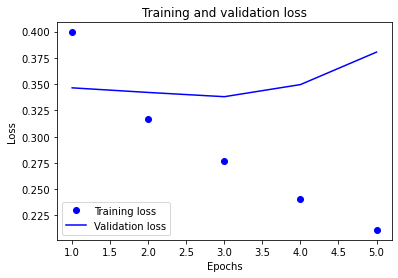

In [20]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

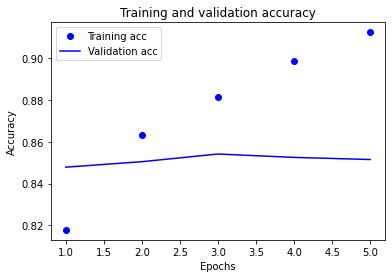

In [21]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석
---

In [22]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [23]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/project/aiffel-lms/E9_Embedding/word2vec_mine.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [24]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.07976415,  0.03918341,  0.01170995,  0.02844974,  0.04866054,
       -0.00688295,  0.06125975,  0.04118128, -0.05804366, -0.00932911,
        0.04627677,  0.06171273, -0.00800136,  0.06663141, -0.04996091,
        0.05542096, -0.00589052,  0.13882327, -0.00888363,  0.03896485,
        0.01152777,  0.01735454, -0.02148382,  0.03666715, -0.0522636 ,
       -0.02198328, -0.00842652,  0.01333505, -0.09706151, -0.01080363,
       -0.07550645, -0.04805997], dtype=float32)

In [25]:
word_vectors.similar_by_word("스릴러")

[('가치', 0.8445396423339844),
 ('.???', 0.8192390203475952),
 ('리암', 0.8046497106552124),
 ('보여요', 0.7947922945022583),
 ('레슬리', 0.7900536060333252),
 ('먹이', 0.7884384989738464),
 ('렵니다', 0.7879118919372559),
 ('신화', 0.7811463475227356),
 ('씹', 0.777438759803772),
 ('쇼킹', 0.7765204906463623)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능개선
---
한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.

https://github.com/Kyubyong/wordvectors

In [26]:
import gensim

word2vec_path = os.getenv('HOME')+'/project/aiffel-lms/E9_Embedding/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

vector = word2vec['영화']
print(vector)

result = word2vec.wv.most_similar("스릴러")
print(result)



[-1.7577837  -1.0874279   1.5300866  -0.1115231  -0.37980682  1.4828517
  1.3180419   0.11094163  0.7430535  -0.45461136  0.58841336  0.5763913
  1.210707    1.3132795  -0.86962503 -0.18507595 -0.47440064  1.5100725
  1.0965794   1.0600823  -0.27457932 -0.70003706  2.3117511   1.4944884
  0.25560892 -2.866659   -0.28312334  0.34263936 -0.67723423  0.71714777
  0.25549442  0.71732044 -0.13262457  0.01792452 -0.3184774   0.5271619
  0.7561084  -2.1247065   1.061429   -0.21065854  0.6877343  -1.4956383
  0.60346967 -2.6955893   0.37694618 -1.0164185   0.5430663   0.1200121
 -2.6315718   0.6216742   1.1583976  -2.5385962   1.326312   -0.10284371
 -0.0286147  -0.9132947   0.7647564   0.79202783 -1.8625957  -0.7418395
  0.5884277  -0.9917992  -0.62114453  1.5367815  -0.6628939   0.6712103
  0.12914915  0.21228492  0.9017655  -0.25083402  0.71500814  0.08644514
  0.59993285  0.5766137   0.64095974  0.47888306 -2.8426213  -2.8502681
 -0.140544   -1.5917364   0.26691505  0.59476066  0.85868204 

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [27]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [28]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, Dense, LSTM


# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
1347/1347 [==============================] - 22s 16ms/step - loss: 0.4098 - accuracy: 0.8101 - val_loss: 0.3468 - val_accuracy: 0.8496
Epoch 2/10
1347/1347 [==============================] - 21s 16ms/step - loss: 0.2968 - accuracy: 0.8742 - val_loss: 0.3198 - val_accuracy: 0.8627
Epoch 3/10
1347/1347 [==============================] - 21s 16ms/step - loss: 0.2466 - accuracy: 0.8980 - val_loss: 0.3269 - val_accuracy: 0.8636
Epoch 4/10
1347/1347 [==============================] - 22s 16ms/step - loss: 0.1988 - accuracy: 0.9203 - val_loss: 0.3595 - val_accuracy: 0.8607
Epoch 5/10
1347/1347 [==============================] - 22s 16ms/step - loss: 0.1550 - accuracy: 0.9399 - val_loss: 0.3691 - val_accuracy: 0.8597
Epoch 6/10
1347/1347 [==============================] - 21s 15ms/step - loss: 0.1140 - accuracy: 0.9578 - val_loss: 0.4542 - val_accuracy: 0.8532
Epoch 7/10
1347/1347 [==============================] - 21s 15ms/step - loss: 0.0820 - accuracy: 0.9701 - val_loss: 0.5015 -

In [30]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7142 - accuracy: 0.8524
[0.714198887348175, 0.852350652217865]


### Reporting
---
아무리 파라미터를 바꾸어봐도 val_accuracy가 학습에 따라 개선되지 않고 큰 차이가 없거나 오히려 떨어지는 모습을 보였는데 왜 그런지 알 수가 없었습니다.....